In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set plot styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Load the data
df = pd.read_csv(r'C:\Users\user\Documents\StrathCaseStudy\New folder\Maize-Production-2012-2018.csv')

# Display the first few rows to understand the structure
print("Dataset Overview:")
print(f"Number of counties: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
df.head(3)

Dataset Overview:
Number of counties: 47
Number of columns: 22


,County,Harvested Area (2012),Production Metric Tonnes (2012),Yield as Production over Harvest (2012),Harvested Area (2013),Production Metric Tonnes (2013),Yield as Production over Harvest (2013),Harvested Area (2014),Production Metric Tonnes (2014),Yield as Production over Harvest (2014),...,Yield as Production over Harvest (2015),Harvested Area (2016),Production Metric Tonnes (2016),Yield as Production over Harvest (2016),Harvested Area (2017),Production Metric Tonnes (2017),Yield as Production over Harvest (2017),Harvested Area (2018),Production Metric Tonnes (2018),Yield as Production over Harvest (2018)
0,Baringo,39753.0,71867.0,1.81,29117.0,55805.0,1.92,34960.0,34959.0,1.00,...,1.89,33163.0,72495.0,2.19,33308.0,45764.0,1.37,37658.0,58475.60,1.55
1,Bomet,32697.0,73278.0,2.24,30620.0,72236.0,2.36,30940.0,53162.0,1.72,...,1.08,32275.0,45517.0,1.41,33792.0,56601.0,1.67,33291.0,58336.81,1.75
2,Bungoma,96209.0,262381.0,2.73,92705.0,221586.0,2.39,98074.0,267302.0,2.73,...,2.67,100712.0,301068.0,2.99,95323.0,289290.0,3.03,93484.0,295481.10,3.16


In [2]:
# Function to extract year from column name
def extract_year(col_name):
    if "(" in col_name and ")" in col_name:
        return col_name.split("(")[1].split(")")[0]
    return None

# Lists to hold the different types of data
harvested_cols = [col for col in df.columns if "Harvested Area" in col]
production_cols = [col for col in df.columns if "Production Metric Tonnes" in col]
yield_cols = [col for col in df.columns if "Yield" in col]

# Create melted dataframes for each data type
harvested_df = pd.melt(df, id_vars=['County'], value_vars=harvested_cols, 
                       var_name='Year_Column', value_name='Harvested_Area')
harvested_df['Year'] = harvested_df['Year_Column'].apply(extract_year)
harvested_df = harvested_df.drop('Year_Column', axis=1)

production_df = pd.melt(df, id_vars=['County'], value_vars=production_cols, 
                        var_name='Year_Column', value_name='Production_MT')
production_df['Year'] = production_df['Year_Column'].apply(extract_year)
production_df = production_df.drop('Year_Column', axis=1)

yield_df = pd.melt(df, id_vars=['County'], value_vars=yield_cols, 
                   var_name='Year_Column', value_name='Yield')
yield_df['Year'] = yield_df['Year_Column'].apply(extract_year)
yield_df = yield_df.drop('Year_Column', axis=1)

# Merge the three dataframes
maize_data = pd.merge(harvested_df, production_df, on=['County', 'Year'])
maize_data = pd.merge(maize_data, yield_df, on=['County', 'Year'])

# Convert Year to integer for easier sorting
maize_data['Year'] = maize_data['Year'].astype(int)

# Sort by County and Year
maize_data = maize_data.sort_values(['County', 'Year'])

# Check the resulting dataframe
print("\nReshaped Dataset:")
print(f"Number of records: {maize_data.shape[0]}")
print(f"Number of columns: {maize_data.shape[1]}")
maize_data.head()


Reshaped Dataset:
Number of records: 329
Number of columns: 5


,County,Harvested_Area,Year,Production_MT,Yield
0,Baringo,39753.0,2012,71867.0,1.81
47,Baringo,29117.0,2013,55805.0,1.92
94,Baringo,34960.0,2014,34959.0,1.00
141,Baringo,44159.0,2015,83313.0,1.89
188,Baringo,33163.0,2016,72495.0,2.19


In [3]:


# Check for any data quality issues
print("\nChecking for missing values:")
print(maize_data.isnull().sum())

# Check for potential outliers or inconsistencies
print("\nSummary statistics:")
print(maize_data.describe())

# Find any very unusual values that may need investigation
print("\nPotential data issues (checking for negative values):")
print("Negative harvested area:", (maize_data['Harvested_Area'] < 0).sum())
print("Negative production:", (maize_data['Production_MT'] < 0).sum())
print("Negative yield:", (maize_data['Yield'] < 0).sum())

print("\nVery large values that might be errors:")
print("Harvested area > 200,000 hectares:", (maize_data['Harvested_Area'] > 200000).sum())
print("Production > 500,000 MT:", (maize_data['Production_MT'] > 500000).sum())
print("Yield > 5:", (maize_data['Yield'] > 5).sum())

# Let's also check for zeros that might indicate missing data
print("\nZero values:")
print("Zero harvested area:", (maize_data['Harvested_Area'] == 0).sum())
print("Zero production:", (maize_data['Production_MT'] == 0).sum())
print("Zero yield:", (maize_data['Yield'] == 0).sum())


Checking for missing values:
County            0
Harvested_Area    0
Year              0
Production_MT     0
Yield             0
dtype: int64

Summary statistics:
       Harvested_Area         Year  Production_MT       Yield
count      329.000000   329.000000     329.000000  329.000000
mean     46377.701337  2015.000000   77929.065167    1.449696
std      39396.485062     2.003046   96222.204826    0.925565
min          0.000000  2012.000000       0.000000    0.000000
25%      16663.000000  2013.000000   12508.000000    0.790000
50%      35549.000000  2015.000000   48121.000000    1.240000
75%      73191.000000  2017.000000   97513.000000    1.890000
max     273056.000000  2018.000000  548196.010000    5.090000

Potential data issues (checking for negative values):
Negative harvested area: 0
Negative production: 0
Negative yield: 0

Very large values that might be errors:
Harvested area > 200,000 hectares: 1
Production > 500,000 MT: 1
Yield > 5: 1

Zero values:
Zero harvested area: 1


In [4]:
# Calculate total production per year
yearly_production = maize_data.groupby('Year')['Production_MT'].sum()
print("\nTotal Kenya Maize Production by Year (Metric Tonnes):")
print(yearly_production)


Total Kenya Maize Production by Year (Metric Tonnes):
Year
2012    3751205.00
2013    3592692.00
2014    3496079.00
2015    3972614.00
2016    3339182.00
2017    3473113.00
2018    4013777.44
Name: Production_MT, dtype: float64


In [5]:
# Calculate total harvested area per year
yearly_harvested = maize_data.groupby('Year')['Harvested_Area'].sum()
print("\nTotal Kenya Maize Harvested Area by Year (Hectares):")
print(yearly_harvested)


Total Kenya Maize Harvested Area by Year (Hectares):
Year
2012    2159321.00
2013    2123140.00
2014    2116142.00
2015    2267152.00
2016    2337586.00
2017    2113180.00
2018    2141742.74
Name: Harvested_Area, dtype: float64


In [6]:
# Calculate average yield per year
yearly_yield = yearly_production / yearly_harvested
print("\nAverage Kenya Maize Yield by Year (MT/Hectare):")
print(yearly_yield)


Average Kenya Maize Yield by Year (MT/Hectare):
Year
2012    1.737215
2013    1.692160
2014    1.652100
2015    1.752249
2016    1.428475
2017    1.643548
2018    1.874071
dtype: float64


In [7]:
# Analyze the top maize-producing counties
top_counties_2018 = maize_data[maize_data['Year'] == 2018].sort_values('Production_MT', ascending=False).head(10)
print("\nTop 10 Maize-Producing Counties in 2018:")
print(top_counties_2018[['County', 'Harvested_Area', 'Production_MT', 'Yield']])


Top 10 Maize-Producing Counties in 2018:
          County  Harvested_Area  Production_MT  Yield
323  Trans Nzoia        107681.0      548196.01   5.09
325  Uasin Gishu         95209.0      405459.68   4.26
284      Bungoma         93484.0      295481.10   3.16
292     Kakamega         95387.0      238290.55   2.50
311     Nairobi          86102.0      238002.40   2.76
314        Narok         91602.0      208306.85   2.27
312       Nakuru         47830.0      179198.25   3.75
297        Kisii         74162.0      154181.90   2.08
307         Meru         82153.0      128126.34   1.56
293      Kericho         33461.0      105402.15   3.15


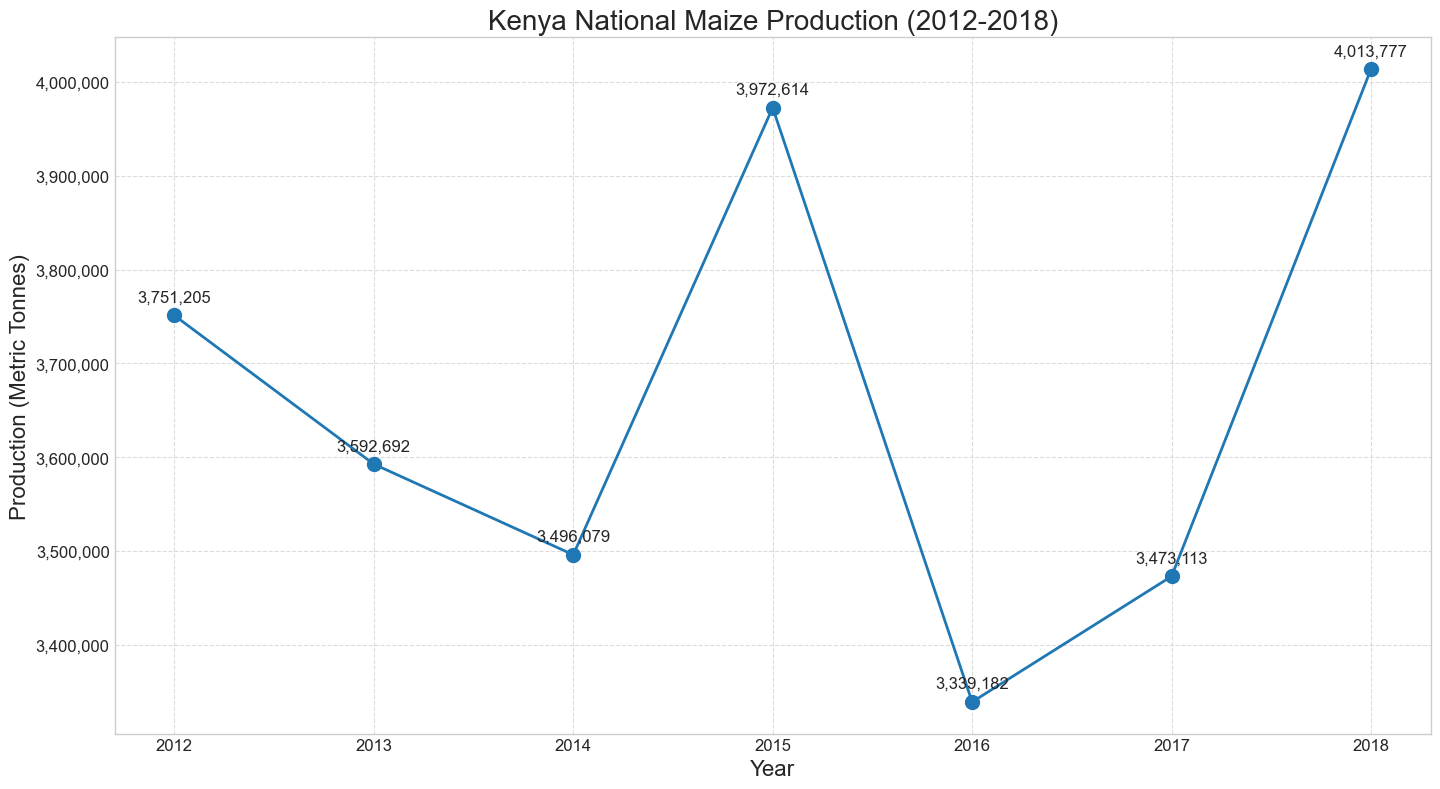

In [8]:
# 1. National Production Trends Over Time
plt.figure(figsize=(14, 8))
plt.plot(yearly_production.index, yearly_production.values, marker='o', linestyle='-', linewidth=2, markersize=10)
plt.title('Kenya National Maize Production (2012-2018)', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Production (Metric Tonnes)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(yearly_production.index)
plt.tight_layout()

# Format y-axis with commas for thousands
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Add data labels above each point
for year, prod in zip(yearly_production.index, yearly_production.values):
    plt.annotate(f'{prod:,.0f}', 
                 (year, prod),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center',
                 fontsize=12)

plt.savefig('kenya_maize_production_trend.png', dpi=300, bbox_inches='tight')
plt.show()

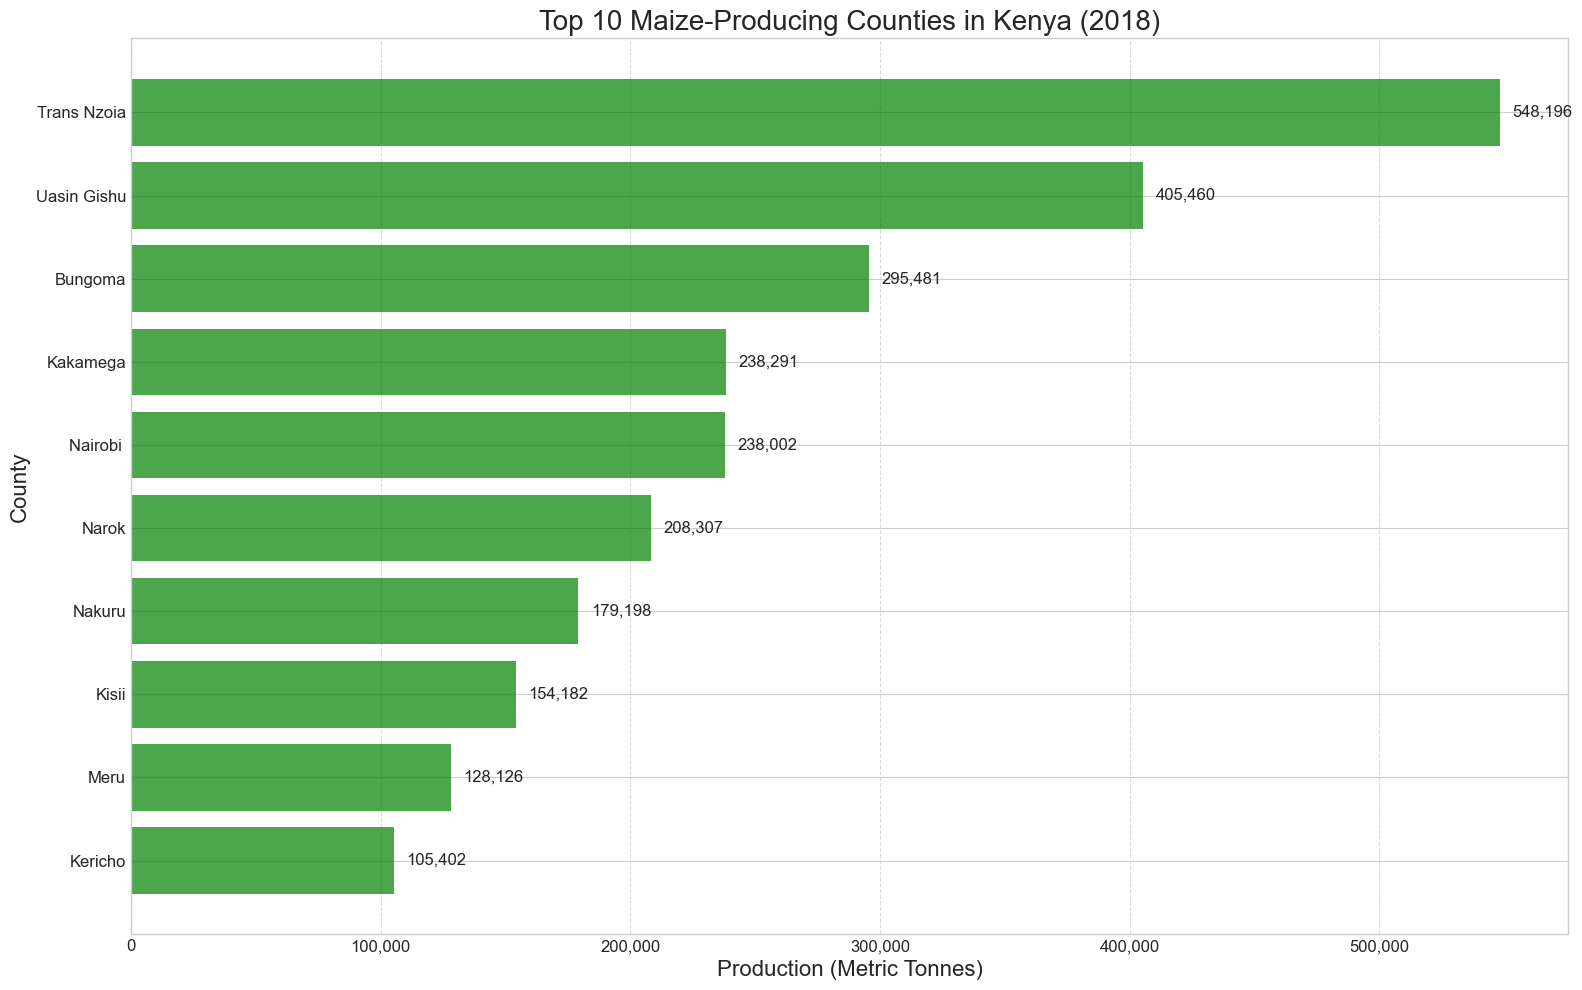

In [9]:
# 2. Top Producing Counties Comparison (2018)
plt.figure(figsize=(16, 10))
top_counties = top_counties_2018.sort_values('Production_MT')

# Create horizontal bar chart
plt.barh(top_counties['County'], top_counties['Production_MT'], color='green', alpha=0.7)
plt.title('Top 10 Maize-Producing Counties in Kenya (2018)', fontsize=20)
plt.xlabel('Production (Metric Tonnes)', fontsize=16)
plt.ylabel('County', fontsize=16)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Format x-axis with commas for thousands
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Add data labels to the end of each bar
for i, prod in enumerate(top_counties['Production_MT']):
    plt.text(prod + 5000, i, f'{prod:,.0f}', va='center', fontsize=12)

plt.tight_layout()
plt.savefig('top_counties_maize_production.png', dpi=300, bbox_inches='tight')
plt.show()

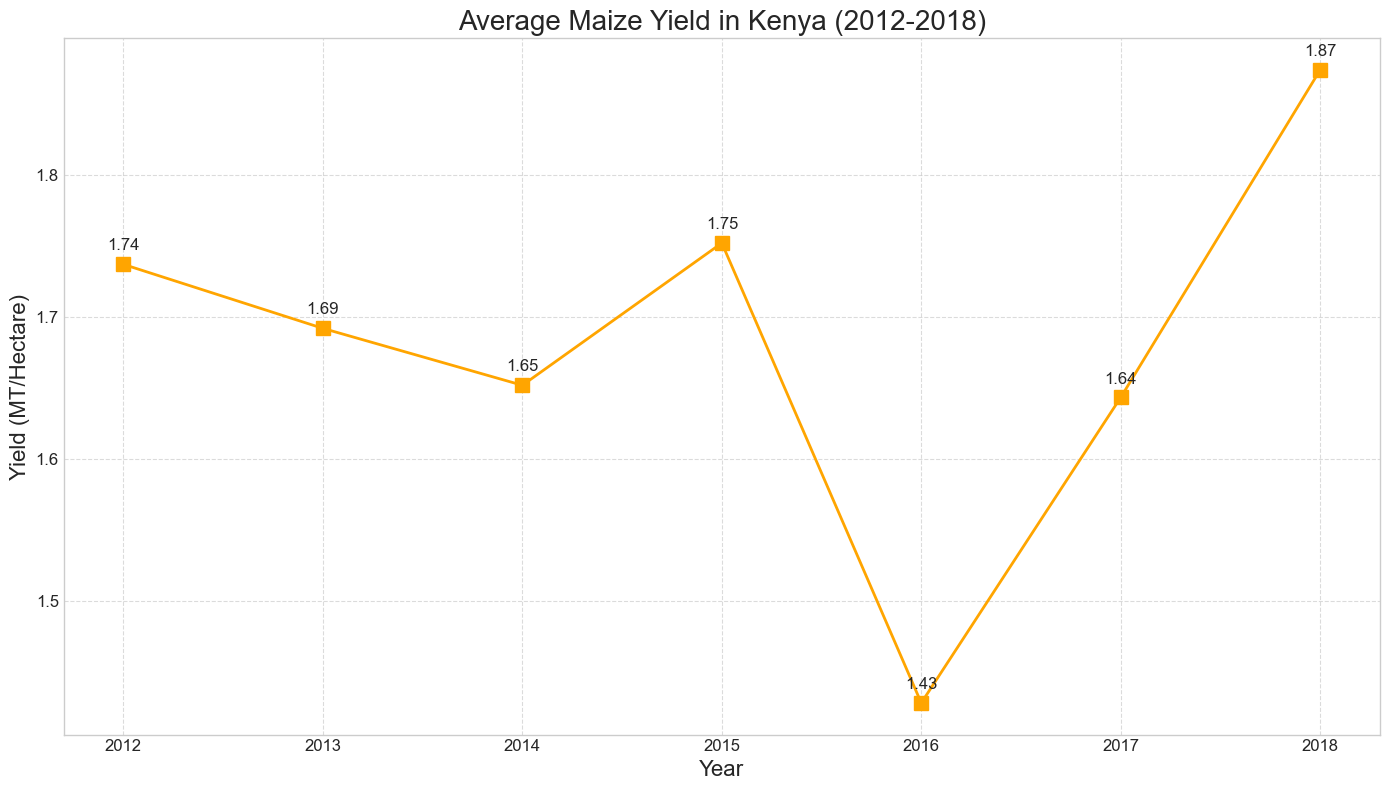

In [10]:
# 3. Yield Comparison Across Years
plt.figure(figsize=(14, 8))
plt.plot(yearly_yield.index, yearly_yield.values, marker='s', linestyle='-', linewidth=2, markersize=10, color='orange')
plt.title('Average Maize Yield in Kenya (2012-2018)', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Yield (MT/Hectare)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(yearly_yield.index)

# Add data labels above each point
for year, yld in zip(yearly_yield.index, yearly_yield.values):
    plt.annotate(f'{yld:.2f}', 
                 (year, yld),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center',
                 fontsize=12)

plt.tight_layout()
plt.savefig('kenya_maize_yield_trend.png', dpi=300, bbox_inches='tight')
plt.show()

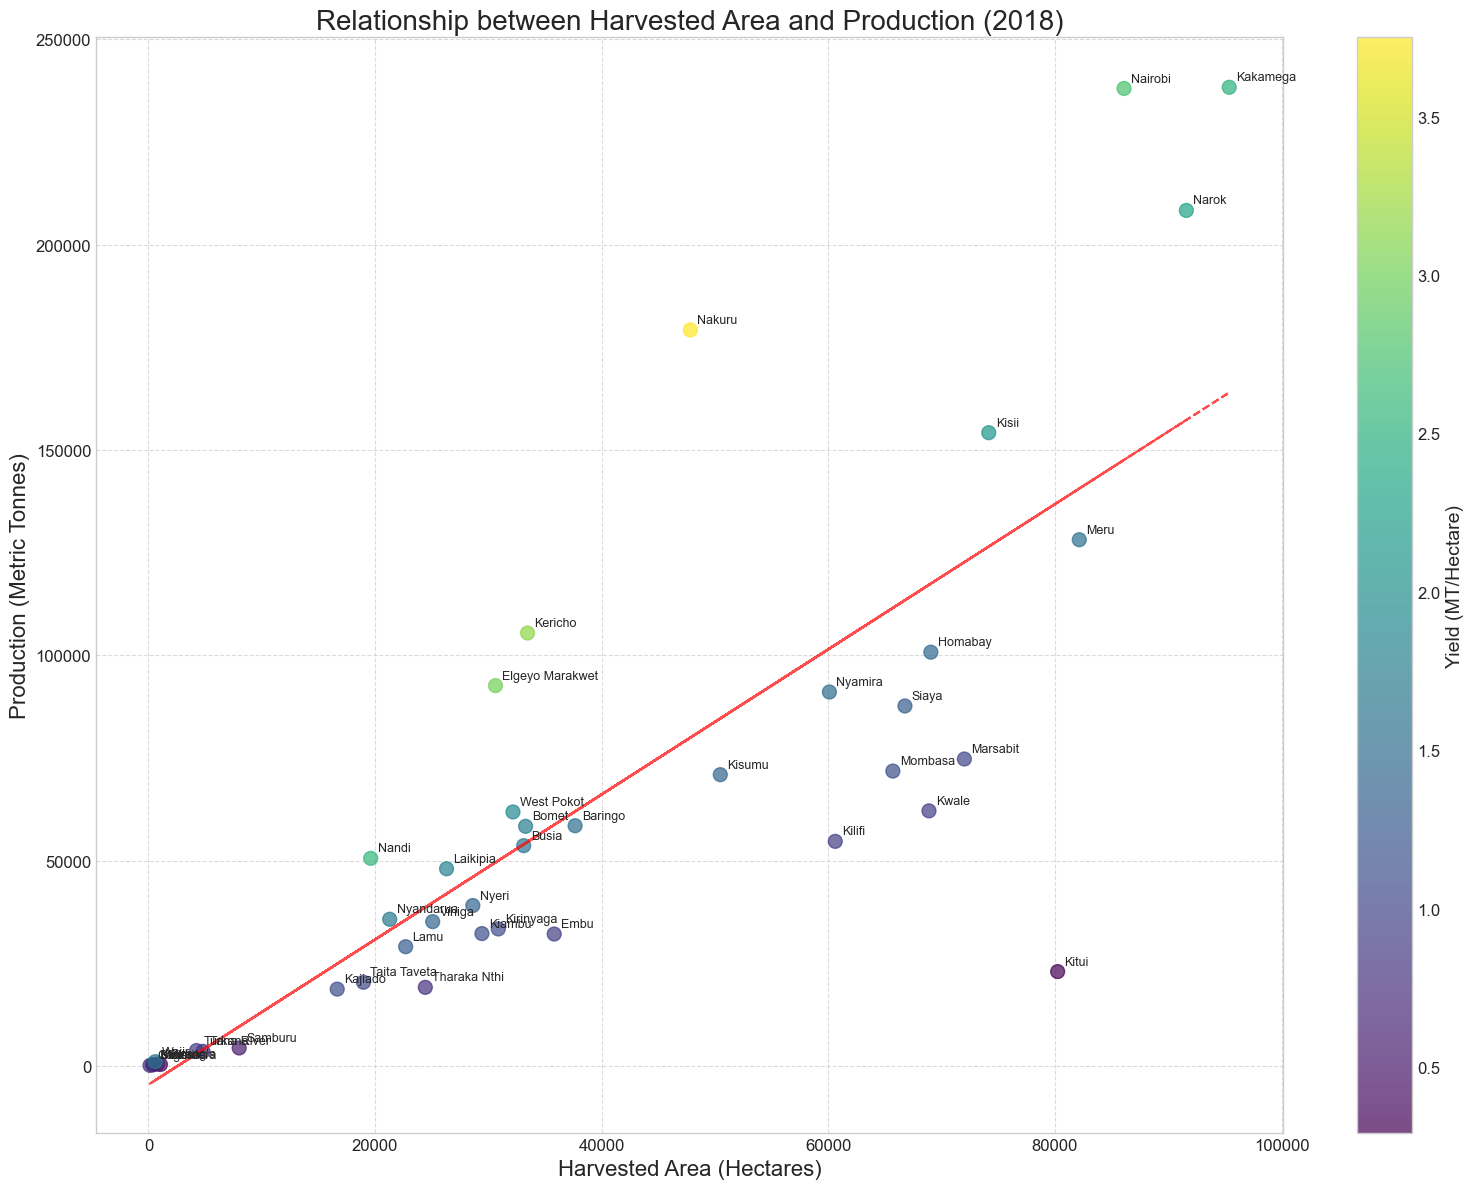

In [11]:
# 4. Production and Area Harvested Relationship (2018)
plt.figure(figsize=(16, 12))
data_2018 = maize_data[maize_data['Year'] == 2018]

# Filter out extreme outliers for better visualization
data_2018_filtered = data_2018[
    (data_2018['Harvested_Area'] <= data_2018['Harvested_Area'].quantile(0.95)) & 
    (data_2018['Production_MT'] <= data_2018['Production_MT'].quantile(0.95))
]

# Create a scatter plot
plt.scatter(data_2018_filtered['Harvested_Area'], 
           data_2018_filtered['Production_MT'], 
           alpha=0.7, 
           s=100, 
           c=data_2018_filtered['Yield'], 
           cmap='viridis')

plt.colorbar(label='Yield (MT/Hectare)')
plt.title('Relationship between Harvested Area and Production (2018)', fontsize=20)
plt.xlabel('Harvested Area (Hectares)', fontsize=16)
plt.ylabel('Production (Metric Tonnes)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# Add county labels to points
for idx, row in data_2018_filtered.iterrows():
    plt.annotate(row['County'], 
                 (row['Harvested_Area'], row['Production_MT']),
                 fontsize=9,
                 xytext=(5, 5),
                 textcoords='offset points')

# Add a best fit line
x = data_2018_filtered['Harvested_Area']
y = data_2018_filtered['Production_MT']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", alpha=0.7)

plt.tight_layout()
plt.savefig('area_production_relationship.png', dpi=300, bbox_inches='tight')
plt.show()

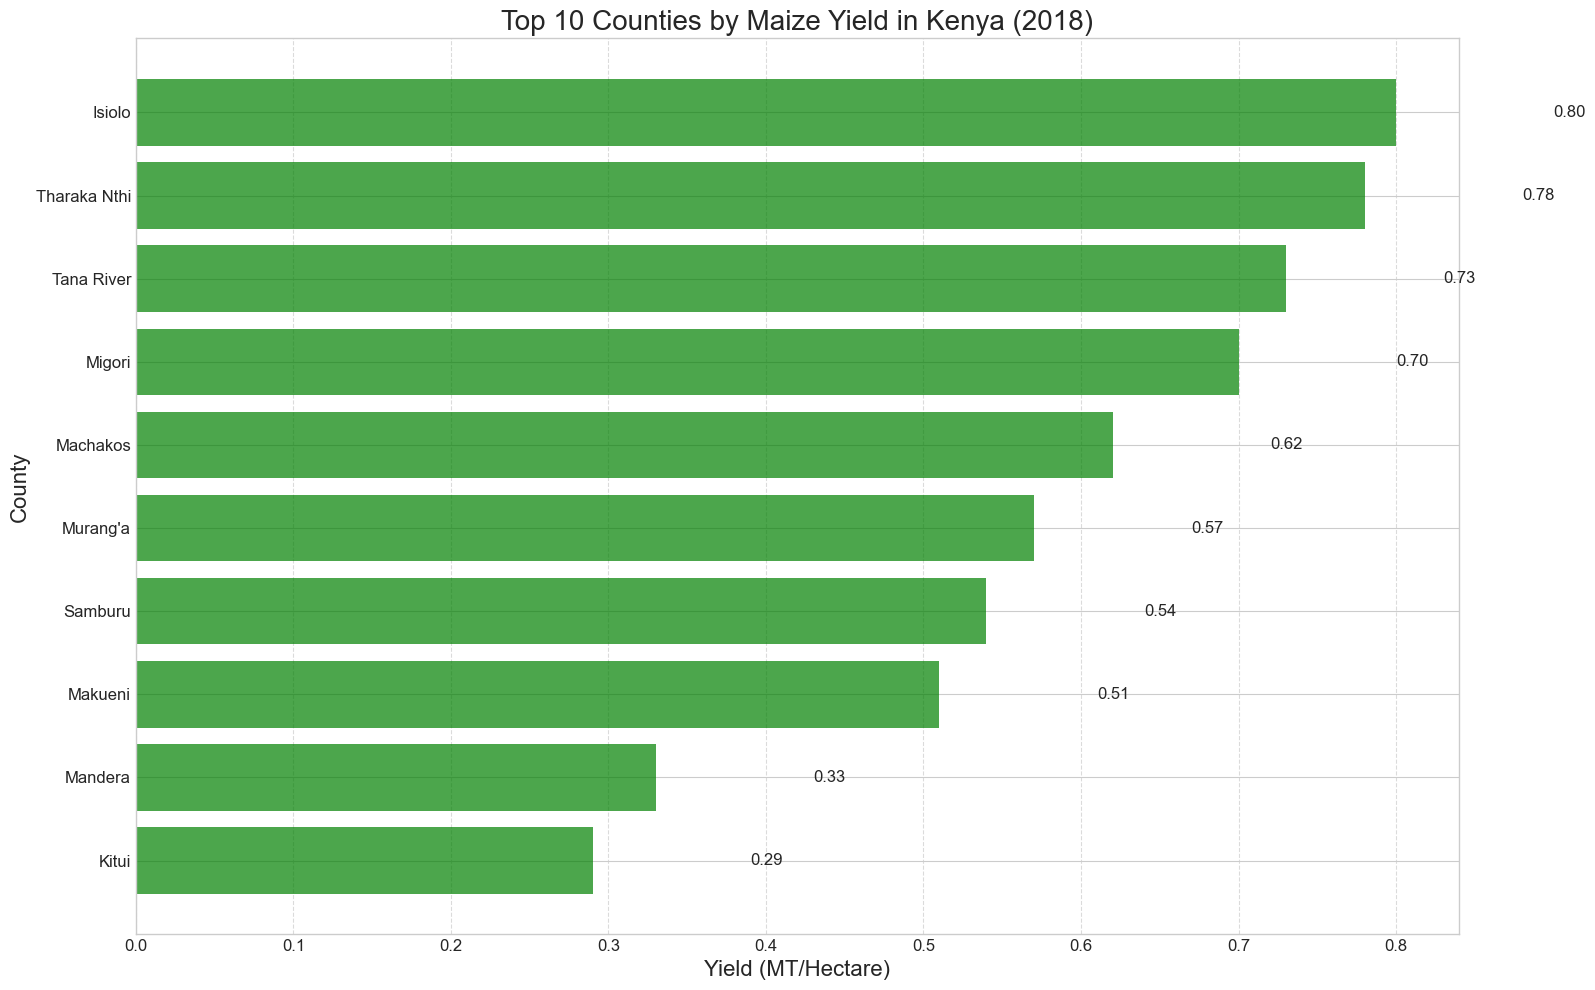

In [14]:
# 5. Top counties comparison by Yield (2018)
plt.figure(figsize=(16, 10))
top_yield_counties = maize_data[maize_data['Year'] == 2018].sort_values('Yield', ascending=True).head(10)

# Create horizontal bar chart for yields
plt.barh(top_yield_counties['County'], top_yield_counties['Yield'], color='green', alpha=0.7)
plt.title('Top 10 Counties by Maize Yield in Kenya (2018)', fontsize=20)
plt.xlabel('Yield (MT/Hectare)', fontsize=16)
plt.ylabel('County', fontsize=16)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Add data labels
for i, yld in enumerate(top_yield_counties['Yield']):
    plt.text(yld + 0.1, i, f'{yld:.2f}', va='center', fontsize=12)

plt.tight_layout()
plt.savefig('top_counties_by_yield.png', dpi=300, bbox_inches='tight')
plt.show()

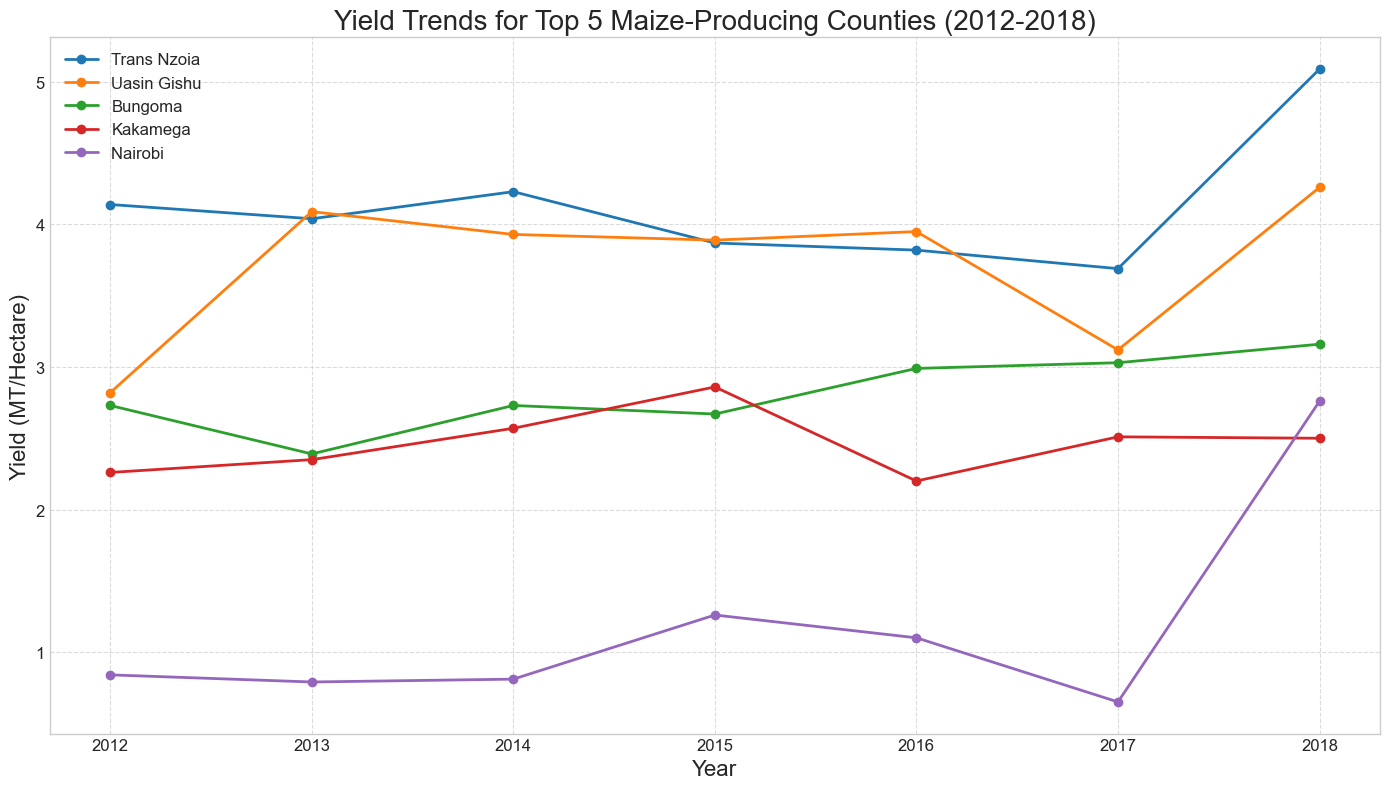

In [15]:
# 6. Historical yield trends for top 5 producing counties
top5_counties = top_counties_2018['County'].head(5).tolist()
top5_data = maize_data[maize_data['County'].isin(top5_counties)]

plt.figure(figsize=(14, 8))
for county in top5_counties:
    county_data = top5_data[top5_data['County'] == county]
    plt.plot(county_data['Year'], county_data['Yield'], marker='o', linewidth=2, label=county)

plt.title('Yield Trends for Top 5 Maize-Producing Counties (2012-2018)', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Yield (MT/Hectare)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(maize_data['Year'].unique())

plt.tight_layout()
plt.savefig('top5_counties_yield_trends.png', dpi=300, bbox_inches='tight')
plt.show()


Top 10 Counties with Highest Production Variability:
County
Nairobi     2.580368
Mombasa     2.542622
Marsabit    2.489524
Wajir       1.159469
Samburu     1.120351
Kilifi      1.006939
Kajiado     0.966897
Laikipia    0.846451
Kwale       0.703715
Migori      0.687729
Name: Production_CV, dtype: float64


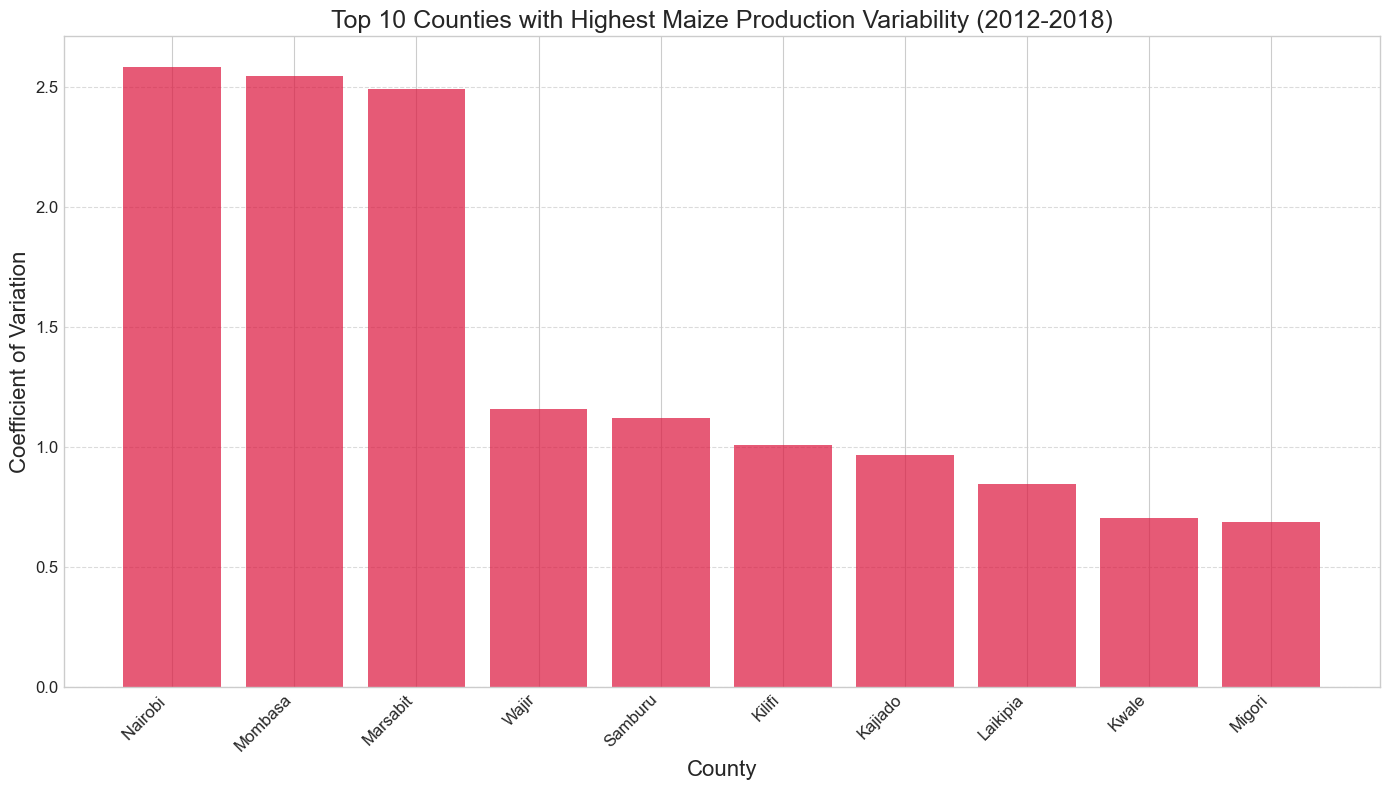

In [16]:
# 8. Production Variability Analysis
# Calculate the coefficient of variation for each county to identify areas with high production variability
county_stats = maize_data.groupby('County').agg({
    'Production_MT': ['mean', 'std', 'min', 'max'],
    'Harvested_Area': ['mean', 'std', 'min', 'max'],
    'Yield': ['mean', 'std', 'min', 'max']
})

# Calculate coefficient of variation (CV = std / mean)
county_stats['Production_CV'] = county_stats[('Production_MT', 'std')] / county_stats[('Production_MT', 'mean')]
county_stats['Yield_CV'] = county_stats[('Yield', 'std')] / county_stats[('Yield', 'mean')]

# Sort by production variability
high_variability_counties = county_stats.sort_values('Production_CV', ascending=False).head(10)
print("\nTop 10 Counties with Highest Production Variability:")
print(high_variability_counties['Production_CV'])

# Plot the counties with high variability
plt.figure(figsize=(14, 8))
counties = high_variability_counties.index
cv_values = high_variability_counties['Production_CV'].values

plt.bar(counties, cv_values, color='crimson', alpha=0.7)
plt.title('Top 10 Counties with Highest Maize Production Variability (2012-2018)', fontsize=18)
plt.xlabel('County', fontsize=16)
plt.ylabel('Coefficient of Variation', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('production_variability_counties.png', dpi=300, bbox_inches='tight')
plt.show()

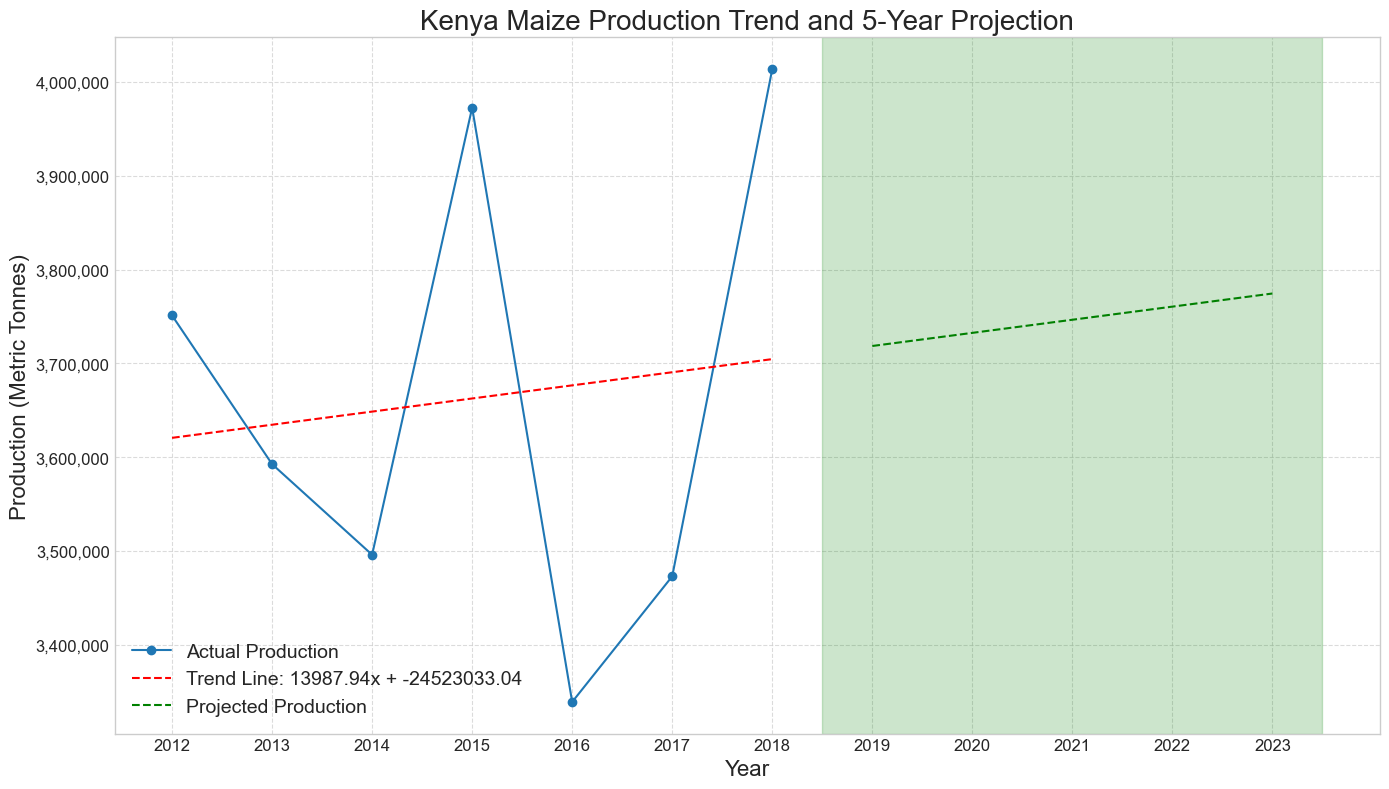


Projected Maize Production for Next 5 Years:
2019: 3,718,618 MT
2020: 3,732,606 MT
2021: 3,746,594 MT
2022: 3,760,582 MT
2023: 3,774,570 MT


In [ ]:
# 9. Time Series Decomposition for National Production
# This helps identify trend, seasonality, and residual components
from statsmodels.tsa.seasonal import seasonal_decompose

# Fit a linear trend line to the production data
x = np.array(yearly_production.index)
y = np.array(yearly_production.values)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# Plot the trend
plt.figure(figsize=(14, 8))
plt.plot(x, y, 'o-', label='Actual Production')
plt.plot(x, p(x), 'r--', label=f'Trend Line: {z[0]:.2f}x + {z[1]:.2f}')

# Project forward 5 years
future_years = np.array(range(2019, 2024))
projected_values = p(future_years)

plt.plot(future_years, projected_values, 'g--', label='Projected Production')

# Highlight the projected region
plt.axvspan(2018.5, 2023.5, alpha=0.2, color='green')

# Add labels and formatting
plt.title('Kenya Maize Production Trend and 5-Year Projection', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Production (Metric Tonnes)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.concatenate([x, future_years]))
plt.legend(fontsize=14)

# Format y-axis with commas for thousands
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.savefig('production_trend_projection.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate and display the projected values
print("\nProjected Maize Production for Next 5 Years:")
for year, proj in zip(future_years, projected_values):
    print(f"{year}: {proj:,.0f} MT")

In [23]:
maize_data.to_csv(r"C:\Users\user\Documents\StrathCaseStudy\New folder\updated_maize_data.csv", index=False)

In [30]:
# 7. Geographical Visualization of Maize Production (2018)

#Import read and display the geojson file
county = r"C:\Users\user\Documents\StrathCaseStudy\New folder\Counties.geojson"
data = gpd.read_file(county)
data.head(6)

,FID,gid,county,pop 2009,lf_endemic,country,counts,var1_class,hiv_class,hiv_his_cl,cuid,geometry
0,0,1,Baringo,555561,No,Kenya,2,2,A,A2,vvOK1BxTbet,"POLYGON ((35.78413 1.65248, 35.78354 1.65287, ..."
1,1,29,Murang'a,942581,No,Kenya,1,2,B,B2,ahwTMNAJvrL,"MULTIPOLYGON (((37.14475 -1.05031, 37.14477 -1..."
2,2,2,Bomet,730129,No,Kenya,1,2,A,A2,HMNARUV2CW4,"POLYGON ((35.45192 -0.36477, 35.45186 -0.36468..."
3,3,3,Bungoma,1375063,No,Kenya,1,3,B,B3,KGHhQ5GLd4k,"POLYGON ((34.62083 1.09942, 34.62018 1.10016, ..."
4,4,4,Busia,743082,No,Kenya,1,2,C,C2,Tvf1zgVZ0K4,"MULTIPOLYGON (((33.91369 0.09826, 33.91369 0.1..."
5,5,5,Elgeyo-marakwet,369998,No,Kenya,2,2,A,A2,MqnLxQBigG0,"POLYGON ((35.5598 1.28418, 35.55973 1.28402, 3..."


In [31]:
data = data.rename(columns={'gid': 'index'})

data.head(1)

,FID,index,county,pop 2009,lf_endemic,country,counts,var1_class,hiv_class,hiv_his_cl,cuid,geometry
0,0,1,Baringo,555561,No,Kenya,2,2,A,A2,vvOK1BxTbet,"POLYGON ((35.78413 1.65248, 35.78354 1.65287, ..."


In [34]:
data_new = data[['county','geometry']]
data_new.head(3)

,county,geometry
0,Baringo,"POLYGON ((35.78413 1.65248, 35.78354 1.65287, ..."
1,Murang'a,"MULTIPOLYGON (((37.14475 -1.05031, 37.14477 -1..."
2,Bomet,"POLYGON ((35.45192 -0.36477, 35.45186 -0.36468..."


In [39]:
data_new.sort_values(by='county', ascending=True, inplace=True)
data_new = data_new.rename(columns={'county': 'County'})

data_new.head()

,County,geometry
0,Baringo,"POLYGON ((35.78413 1.65248, 35.78354 1.65287, ..."
2,Bomet,"POLYGON ((35.45192 -0.36477, 35.45186 -0.36468..."
3,Bungoma,"POLYGON ((34.62083 1.09942, 34.62018 1.10016, ..."
4,Busia,"MULTIPOLYGON (((33.91369 0.09826, 33.91369 0.1..."
5,Elgeyo-marakwet,"POLYGON ((35.5598 1.28418, 35.55973 1.28402, 3..."


In [36]:
# Filter for 2018 only from maize_data 
data_year = 2018  
filtered_data = maize_data[maize_data['Year'] == data_year]
filtered_data.head(3)

,County,Harvested_Area,Year,Production_MT,Yield
282,Baringo,37658.0,2018,58475.60,1.55
283,Bomet,33291.0,2018,58336.81,1.75
284,Bungoma,93484.0,2018,295481.10,3.16


In [ ]:
# Merge Maize Data with GeoData
# Merge on county name
merged_data = data_new.merge(filtered_data, on='County', how='left')
merged_data.head(3)

,County,geometry,Harvested_Area,Year,Production_MT,Yield
0,Baringo,"POLYGON ((35.78413 1.65248, 35.78354 1.65287, ...",37658.0,2018.0,58475.60,1.55
1,Bomet,"POLYGON ((35.45192 -0.36477, 35.45186 -0.36468...",33291.0,2018.0,58336.81,1.75
2,Bungoma,"POLYGON ((34.62083 1.09942, 34.62018 1.10016, ...",93484.0,2018.0,295481.10,3.16


In [41]:
# Metric to visualize
metric = 'Production_MT' 

# Define colormap and legend title
if metric == 'Production_MT':
    cmap = 'YlGn'
    legend_title = 'Production (MT)'
elif metric == 'Harvested_Area':
    cmap = 'BuPu'
    legend_title = 'Harvested Area (Ha)'
else:
    cmap = 'RdYlGn'
    legend_title = 'Yield (MT/Ha)'


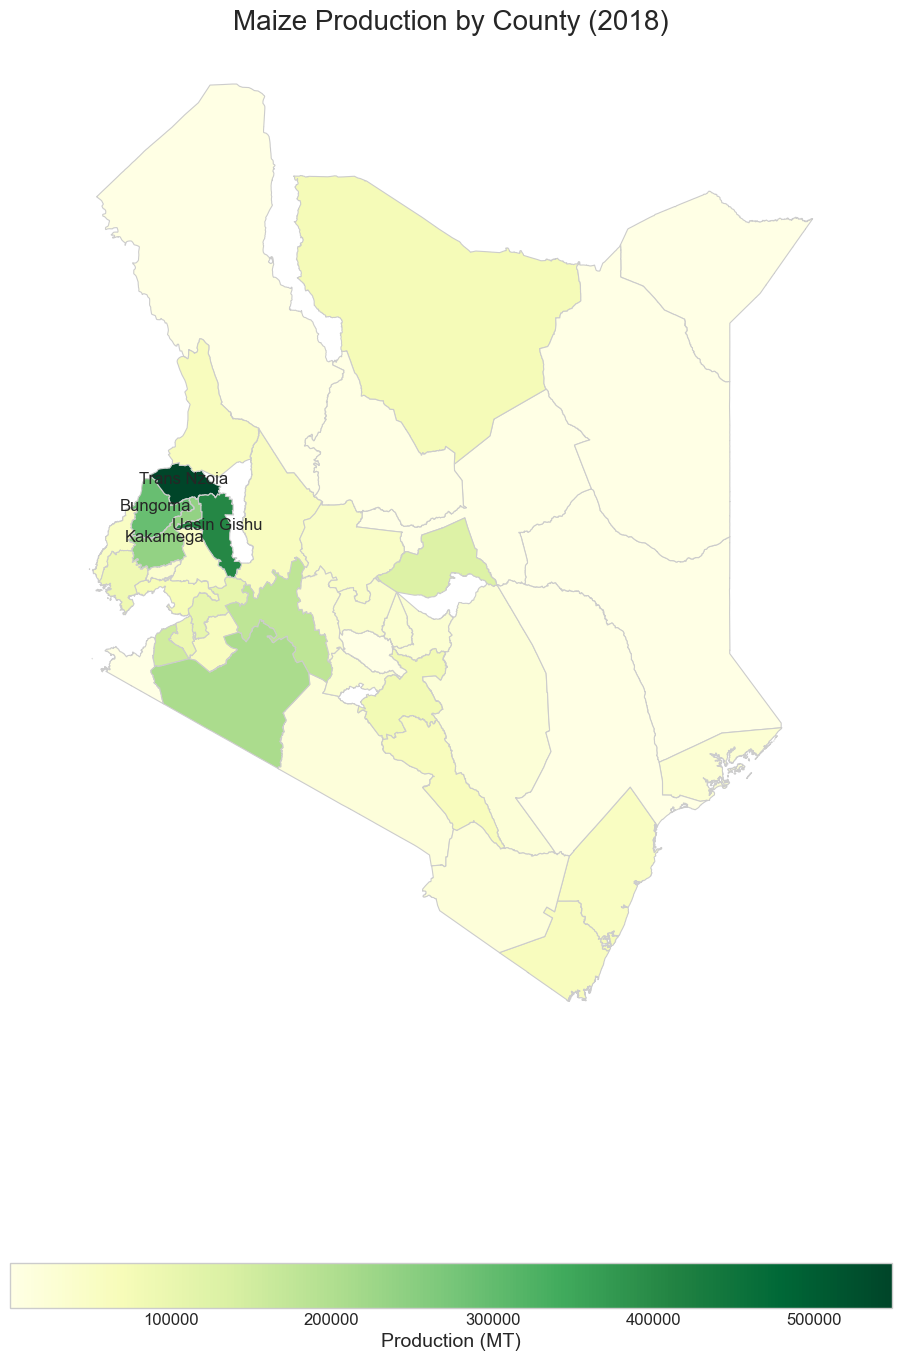

In [44]:
# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Plot counties shaded by the metric
merged_data.plot(
    column=metric,
    cmap=cmap,
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={
        'label': legend_title,
        'orientation': 'horizontal',
        'shrink': 0.6
    }
)

# Title and hide axes
ax.set_title(f'Maize Production by County ({data_year})', fontsize=20)
ax.set_axis_off()

# Label the top 5 counties on the map
top_counties = filtered_data.sort_values(metric, ascending=False).head(5)

for _, row in top_counties.iterrows():
    county_geom = merged_data[merged_data['County'] == row['County']]
    if not county_geom.empty:
        centroid = county_geom.geometry.centroid
        ax.annotate(
            row['County'],
            (centroid.x.values[0], centroid.y.values[0]),
            fontsize=12,
            ha='center'
        )
plt.tight_layout()
plt.show()



In [ ]:
# Save the merged data for future reference
merged_data.to_file(r"C:\Users\user\Documents\StrathCaseStudy\New folder\merged_maize_data.geojson", driver='GeoJSON')

In [51]:
import plotly.express as px
import plotly.io as pio

# Convert to GeoJSON string for Plotly
kenya_geojson = merged_data.__geo_interface__

# Metric to visualize
metric = 'Harvested_Area'  # Change this to 'Production_MT' or 'Yield' as needed


# Create a Plotly map 
fig = px.choropleth_mapbox(
    merged_data,
    geojson=kenya_geojson,
    locations=merged_data.index,  
    color=metric,
    hover_name="County",
    hover_data={metric: True, "County": False},  
    mapbox_style="carto-positron",
    center={"lat": 0.5, "lon": 37.5},
    zoom=5.5,
    color_continuous_scale="YlGn",
    title=f"Kenya Harvest Area by County ({data_year})"
)

fig.update_layout(margin={"r":0, "t":50, "l":0, "b":0})
pio.renderers.default = 'browser'
fig.show()


Above code opens in browser


### Part Two On Retail Prices

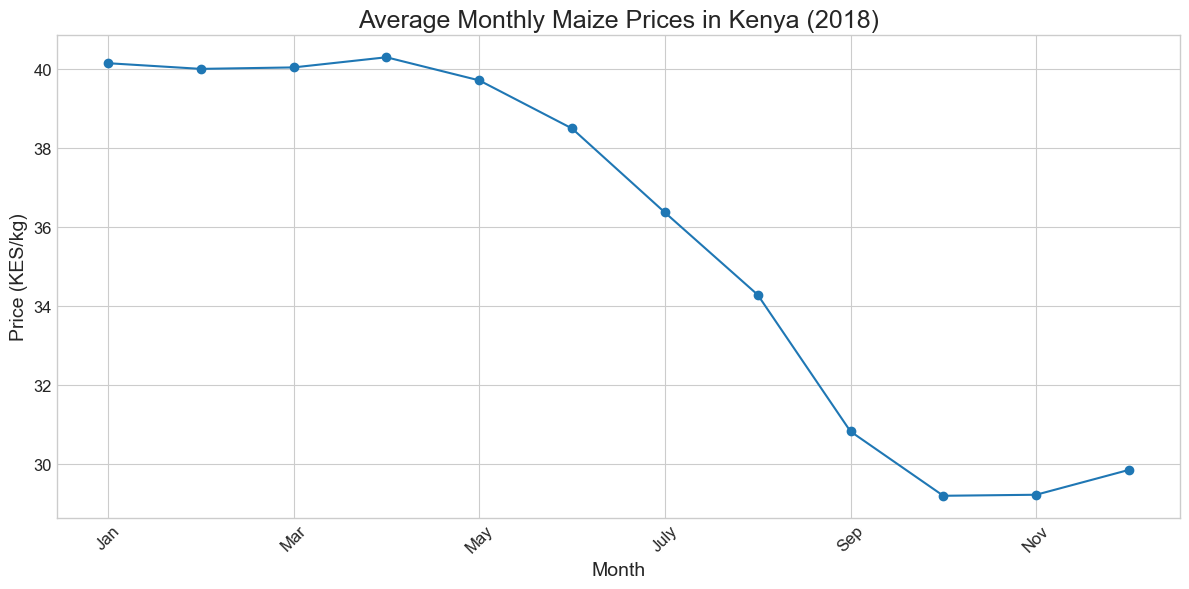

In [24]:
# Load
df = pd.read_csv(r'C:\Users\user\Documents\StrathCaseStudy\New folder\retail-prices-for-dry-maize-year-2018.csv')

# --- Average Monthly Prices Across All Markets ---
monthly_avg_prices = df.drop(columns='Month').mean()

# Plot national average monthly maize prices
plt.figure(figsize=(12, 6))
monthly_avg_prices.plot(marker='o')
plt.title('Average Monthly Maize Prices in Kenya (2018)')
plt.xlabel('Month')
plt.ylabel('Price (KES/kg)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

High prices were observed in November and December, suggesting increased demand or reduced supply (possibly post-harvest depletion).

Lower prices appeared around May to July, which may align with harvest periods in some regions.

Some markets (e.g., Nairobi, Mombasa) exhibit relatively stable pricing, reflecting consistent supply/demand or buffering via imports.

Other markets (e.g., rural or agriculturally active areas) show strong seasonal fluctuations, 

with price dips mid-year (likely harvest time) and price spikes at the start and end of the year (lean seasons).


This highlights how seasonality impacts maize prices differently across regions, likely due to:

Proximity to production zones,

Transport infrastructure,

Local demand dynamics.

In [25]:
# Reshape to long format for plotting
df_long = df.melt(id_vars='Month', var_name='Month_Name', value_name='Price')
df_long = df_long.dropna()


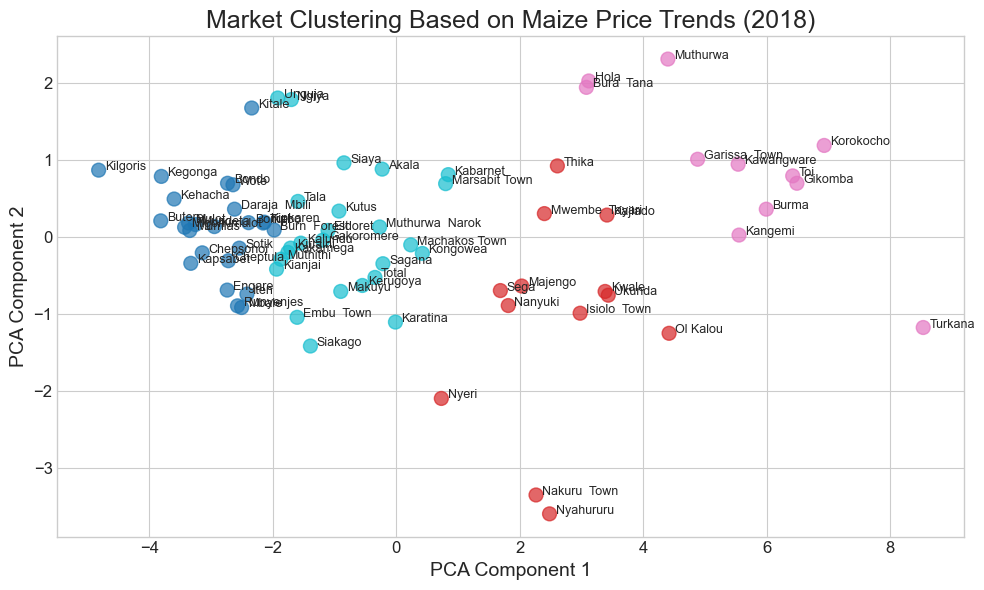

In [26]:
# ----- Clustering by Price Patterns -----
# Prepare data: drop markets with excessive missing data, fill others
price_data = df.set_index('Month')
price_data_clean = price_data.dropna(thresh=6)
price_data_filled = price_data_clean.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

# Standardize for clustering
scaler = StandardScaler()
price_scaled = scaler.fit_transform(price_data_filled)

# PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(price_scaled)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(price_scaled)

# Plot clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='tab10', s=100, alpha=0.7)
for i, market in enumerate(price_data_filled.index):
    plt.text(pca_result[i, 0] + 0.1, pca_result[i, 1], market, fontsize=9)
plt.title('Market Clustering Based on Maize Price Trends (2018)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

##### Explanation

PCA Component 1 and PCA Component 2 are principal components that reduce the dimensionality of the maize price data.

They represent combinations of all the monthly price values in a way that maximizes variation by separating markets with different behavior.

Each dot represents one individual market.

Markets are grouped into 4 clusters based on their price trend similarities throughout 2018.

Each cluster reflects markets with similar price behavior patterns.

##### Interpretations

Example 1: Cluster on far right (e.g. Turkana, Korokoch, Dandora)
These are likely high-price or highly volatile markets.

Could be remote or have logistics/supply issues.

Example 2: Cluster on bottom-left (e.g. Nyeri, Nakuru, Nyahururu)
May have lower or more stable prices.

Possibly production-heavy regions or those close to supply.

Example 3: Dense cluster in center-left (e.g. Kisumu, Kakamega, Kisii, Kitale)
These markets show very similar seasonal price curves, 
suggesting they are well-integrated or influenced by shared harvest calendars or infrastructure.

##### Recommendations
Design region-specific policies (e.g., subsidies or logistics support for high-price clusters).

Streamline distribution by grouping similar markets for storage and delivery.

Target price stabilization efforts more efficiently.

In [27]:
# ----- Output Table: Market Cluster Membership -----
market_clusters = pd.DataFrame({
    'Market': price_data_filled.index,
    'Cluster': clusters
}).sort_values(by='Cluster')

market_clusters.reset_index(drop=True, inplace=True)
market_clusters

,Market,Cluster
0,Kegonga,0
1,Sotik,0
2,Kehacha,0
3,Kipkaren,0
4,Kitale,0
...,...,...
69,Makuyu,3
70,Marsabit Town,3
71,Muthithi,3
72,Ngiya,3


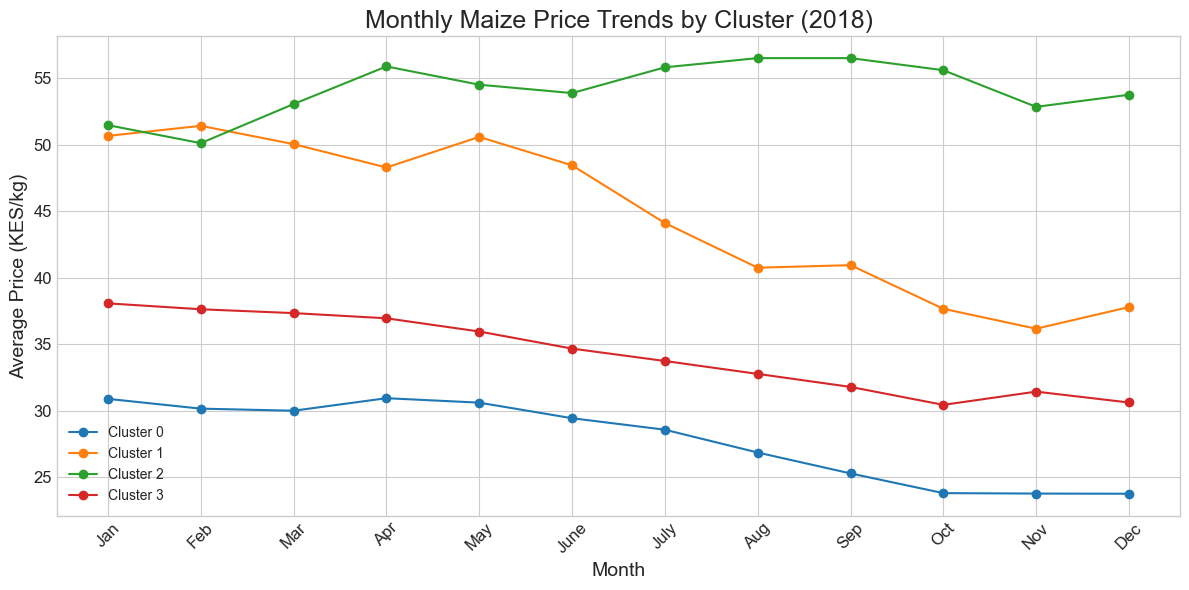

In [28]:
# Add cluster labels to data
price_data_clustered = price_data_filled.copy()
price_data_clustered['Cluster'] = clusters

# Compute average monthly prices per cluster
cluster_monthly_avg = price_data_clustered.groupby('Cluster').mean()

# Plot monthly maize price trends by cluster
plt.figure(figsize=(12, 6))
for cluster_id in cluster_monthly_avg.index:
    plt.plot(cluster_monthly_avg.columns, cluster_monthly_avg.loc[cluster_id], marker='o', label=f'Cluster {cluster_id}')

plt.title('Monthly Maize Price Trends by Cluster (2018)')
plt.xlabel('Month')
plt.ylabel('Average Price (KES/kg)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Insights by Cluster:

Cluster 0: Prices start high, dip mid-year, and rise again—classic harvest cycle effect.

Cluster 1: Prices remain consistently high, indicating urban or transport-constrained markets.

Cluster 2: Lower average prices with minor fluctuation, likely production zones or well-supplied regions.

Cluster 3: More erratic behavior, possibly mixed rural/urban or variable supply chain zones.